In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!cp "/content/gdrive/My Drive/DAGM2007/DAGM2007.zip" .
!unzip -q DAGM2007.zip

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten
from keras.optimizers import RMSprop
#from keras_tqdm import TQDMNotebookCallback

In [0]:
class CNN(object):
    def __init__(self, input_shape, first_layer_channels):
        self.CONV_FILTER_SIZE = 3
        self.CONV_STRIDE = 1
        self.POOLING_FILTER_SIZE = 2
        self.POOLING_STRIDE = 1

        # input (32 x 32 x 1)
        inputs = Input(input_shape)

        # c1 (32 x 32 x N)
        filter_count = first_layer_channels
        c1 = Conv2D(filter_count, self.CONV_FILTER_SIZE, strides=self.CONV_STRIDE, padding='same', activation='relu')(inputs)
        
        # s1 (16 x 16 x N)
        s1 = MaxPooling2D()(c1)
        
        # c2 (16 x 16 x 2N)
        filter_count = first_layer_channels*2
        c2 = Conv2D(filter_count, self.CONV_FILTER_SIZE, strides=self.CONV_STRIDE, padding='same', activation='relu')(s1)
        
        # s2 (8 x 8 x 2N)
        s2 = MaxPooling2D()(c2)
        
        # c3 ( 8 x 8 x 4N)
        filter_count = first_layer_channels*4
        c3 = Conv2D(filter_count, self.CONV_FILTER_SIZE, strides=self.CONV_STRIDE, padding='same', activation='relu')(s2)
        
        # s3 (4 x 4 x 4N)
        s3 = MaxPooling2D()(c3)
        
        # fc1 (512)
        fc1 = Flatten()(s3)
        fc1 = Dense(512, activation='relu')(fc1)
        
        # fc2 (256)
        fc2 = Dense(256, activation='relu')(fc1)

        # output2
        output = Dense(1, activation='sigmoid')(fc2)
        
        self.CNN = Model(inputs=inputs, outputs=output)
        
        # modelの詳細表示
        print(self.CNN.summary())
        
    def get_model(self):
        return self.CNN

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from skimage import io, img_as_float
from skimage.draw import ellipse
%matplotlib inline

In [0]:
def load_labels(imgdir):
    txtpath = imgdir+'labels.txt'
    
    f = open(txtpath)
    lines = f.readlines()
    f.close()
    
    labels = []
    for line in lines:
        if line == 'tr':
            break
        label = list(map(float, line.split()))
        labels.append(label)
    
    masks = []
    for i in range(150):
        imgpath = imgdir+str(i+1)+'.png'
        img = io.imread(imgpath)
        
        mask = np.zeros(img.shape)
        _, c_radius, r_radius, rotaion, col, raw = labels[i]
        rr, cc = ellipse(raw, col, r_radius, c_radius, shape=mask.shape, rotation=-1*rotaion)
        mask[rr, cc] = 1
        masks.append(mask)
        
    return labels, masks

In [0]:
def load_train_datas(imgdir, block_size, block_stride):
    x_train = []
    y_train = []
    labels, masks = load_labels(imgdir)
    for n in range(50):
        imgpath = imgdir+str(n+1)+'.png'
        img = plt.imread(imgpath)
        img = img_as_float(img)
        img_rois, mask_rois, _ = crop_rois(img, masks[n], block_size, block_stride, False)
        x_train += img_rois
        y_train += mask_rois
    
    x_train = np.array(x_train).reshape(len(x_train), block_size, block_size, 1)
    y_train = np.array(y_train)
    return x_train, y_train

In [0]:
def load_valid_datas(imgdir, block_size, block_stride):
    x_valid = []
    y_valid = []
    labels, masks = load_labels(imgdir)
    for n in range(50,70):
        imgpath = imgdir+str(n+1)+'.png'
        img = plt.imread(imgpath)
        img = img_as_float(img)
        img_rois, mask_rois, _ = crop_rois(img, masks[n], block_size, block_stride, False)
        x_valid += img_rois
        y_valid += mask_rois
    
    x_valid = np.array(x_valid).reshape(len(x_valid), block_size, block_size, 1)
    y_valid = np.array(y_valid)
    return x_valid, y_valid

In [0]:
def crop_rois(img, mask, bsize, bstride, flag):
    height, width = img.shape
    img_rois = []
    mask_rois = []
    roi_pos = []
    if flag == True:
        # ブロックストライドなし
        for y in range(int(height/bsize)):
            for x in range(int(width/bsize)):
                px, py = (x*bsize, y*bsize)
                img_roi = img[px:px+bsize, py:py+bsize]
                mask_roi = mask[px:px+bsize, py:py+bsize]
                if img_roi.shape == (bsize, bsize):
                    img_rois.append(img_roi)
                    roi_pos.append((px,py))
                    if np.sum(mask_roi) != 0:
                        mask_rois.append(1)
                    else:
                        mask_rois.append(0)
    else:
        # ブロックストライドあり
        for y in range(int(height/bstride)):
            for x in range(int(width/bstride)):
                px, py = (x*bstride, y*bstride)
                img_roi = img[py:py+bsize, px:px+bsize]
                mask_roi = mask[py:py+bsize, px:px+bsize]
                
                if img_roi.shape == (bsize, bsize):
                    img_rois.append(img_roi)
                    roi_pos.append((px,py))
                    if np.sum(mask_roi) != 0:
                        mask_rois.append(1)
                    else:
                        mask_rois.append(0)

    return img_rois, mask_rois, roi_pos

In [0]:
def train():
    # 学習ブロックサイズ＆ストライド 
    block_size = 32
    block_stride = 16
    
    # 学習Class(1～6の数字)
    for num in range(1,7):
      # 学習画像ディレクトリ
      imgdir = './DAGM2007/Class'+str(num)+'_def/'
      x_train, y_train = load_train_datas(imgdir, block_size, block_stride)
      print(x_train.shape, y_train.shape)
      x_valid, y_valid = load_valid_datas(imgdir, block_size, block_stride)
      print(x_valid.shape, y_valid.shape)

      # ネットワークパラメータ
      batch_size = 32
      epochs = 10
      input_shape = (block_size, block_size, 1)
      first_layer_channels = 32

      # CNNモデルの構築
      cnn = CNN(input_shape, first_layer_channels)
      model = cnn.get_model()
      model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['acc'])
      fit = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid))
      model.save_weights('weights'+str(num)+'.hdf5')

      plt.figure(figsize=(10,5))
      plt.subplot(121)
      plt.title('model loss')
      plt.plot(fit.history['loss'], label='training')
      plt.plot(fit.history['val_loss'], label='validation')
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.legend()
      plt.subplot(122)
      plt.title('model accuracy')
      plt.plot(fit.history['acc'], label='training')
      plt.plot(fit.history['val_acc'], label='validation')
      plt.xlabel('epochs')
      plt.ylabel('accuracy')
      plt.legend()
      plt.show()

(48050, 32, 32, 1) (48050,)
(19220, 32, 32, 1) (19220,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_18 (Ma

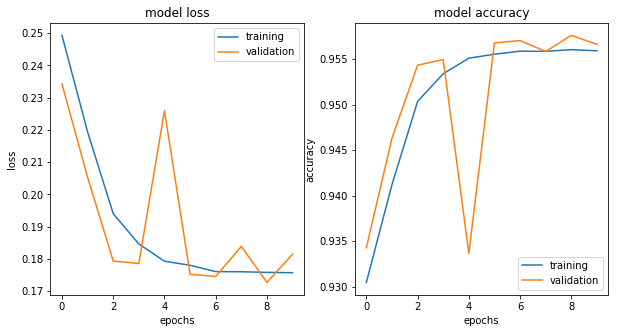

(48050, 32, 32, 1) (48050,)
(19220, 32, 32, 1) (19220,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_21 (Ma

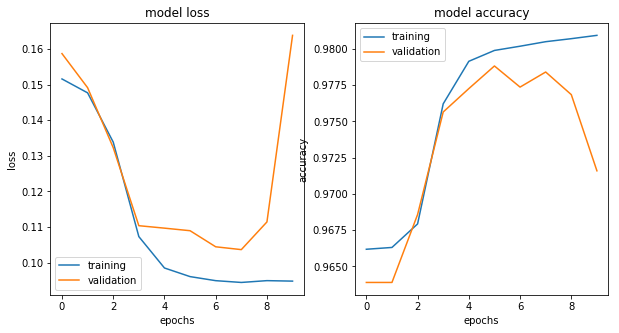

(48050, 32, 32, 1) (48050,)
(19220, 32, 32, 1) (19220,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_24 (Ma

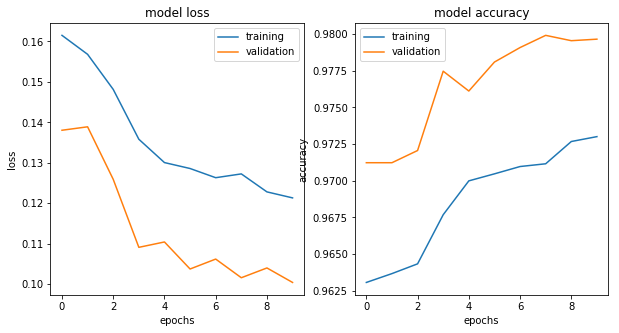

(48050, 32, 32, 1) (48050,)
(19220, 32, 32, 1) (19220,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_27 (Ma

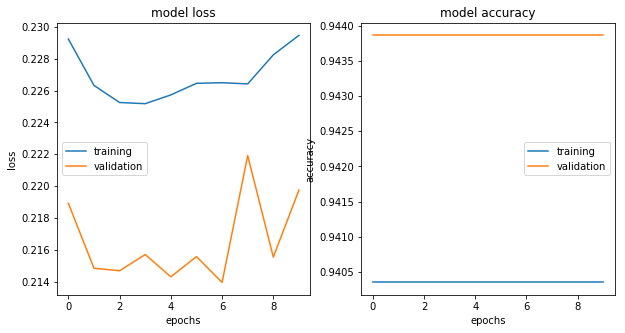

(48050, 32, 32, 1) (48050,)
(19220, 32, 32, 1) (19220,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_30 (Ma

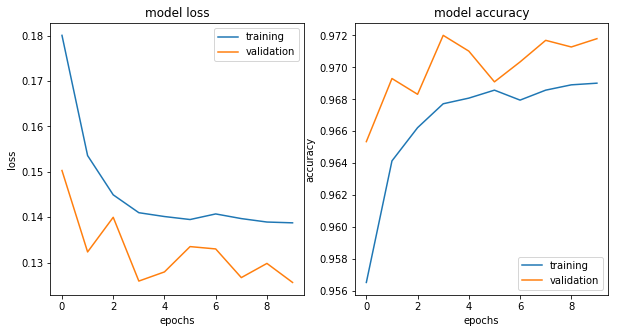

(48050, 32, 32, 1) (48050,)
(19220, 32, 32, 1) (19220,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_33 (Ma

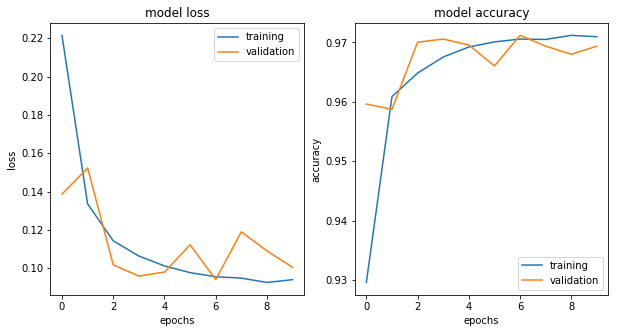

In [22]:
train()

In [0]:
def load_test_datas(imgpath, mask, block_size, block_stride):
    x_test = []
    y_test = []

    img = plt.imread(imgpath)
    img = img_as_float(img)
    img_rois, mask_rois, roi_pos = crop_rois(img, mask, block_size, block_stride, False)
    x_test += img_rois
    y_test += mask_rois
    
    x_test = np.array(x_test).reshape(len(x_test), block_size, block_size, 1)
    y_test = np.array(y_test)
    return x_test, y_test, roi_pos

In [0]:
def test():
    # 学習ブロックサイズ＆ストライド 
    block_size = 32
    block_stride = 16

    # ネットワークパラメータ
    batch_size = 32
    first_layer_channels = 32

    # 検査Class(1～6の数字)
    for num in range(1,7):
      print("Class"+str(num))
      # 学習画像ディレクトリ
      imgdir = './DAGM2007/Class'+str(num)+'_def/'

      # ラベル＆マスクの読み込み
      labels, masks = load_labels(imgdir)

      # cnnモデルの読み込み
      input_shape = (block_size, block_size, 1)
      cnn = CNN(input_shape, first_layer_channels)
      model = cnn.get_model()
      model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['acc'])
      model.load_weights('weights'+str(num)+'.hdf5')

      for i in range(70, 75):
          testpath = imgdir+str(i+1)+'.png'
          test_img = img_as_float(io.imread(testpath))
          x_test, y_test, roi_pos = load_test_datas(testpath, masks[i], block_size, block_stride)

          score = model.evaluate(x_test, y_test, verbose=0)

          print('Test score:', score[0])
          print('Test accuracy:', score[1])

          pred = model.predict(x_test)
          res_img = np.zeros(masks[i].shape)
          for j, pos in enumerate(roi_pos):
              x, y = pos
              res_img[y:y+block_size, x:x+block_size] = pred[j]

          _, c_radius, r_radius, rotation, col, raw = labels[i]

          fig = plt.figure(figsize=(12,5))
          ax1 = fig.add_subplot(1,2,1)
          ax1.imshow(test_img, cmap='gray')
          e = pat.Ellipse(xy = (int(col), int(raw)), width = int(c_radius*2), height = int(r_radius*2), angle = int(rotation/3.14*180), fill=False, color='red')
          ax1.add_patch(e)
          ax2 = fig.add_subplot(1,2,2)
          im2 = ax2.imshow(res_img, cmap='plasma')
          fig.colorbar(im2, ax=ax2)
          plt.show()

In [25]:
test()

Output hidden; open in https://colab.research.google.com to view.